In [1]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 211 kB 57.7 MB/s 
     |████████████████████████████████| 182 kB 67.3 MB/s 
     |████████████████████████████████| 7.6 MB 37.8 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 93 kB 3.0 MB/s 
     |████████████████████████████████| 7.4 MB 37.3 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=764c2e668b311f4c778a0b9d81881b4f70ad0730c6fdbb0f350ea362c266ae5b
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=a82dc12b8cf04411caca72d031e0a77a796db461596094254d679095ce56e88a
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c23

In [2]:
# ! python -m spacy download en_core_web_sm

In [101]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from newspaper import Article
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers import pipeline
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

In [6]:
TARGET = 'label'
TEXT = 'text'

In [7]:
def get_html_files(html_folder=HTML_FOLDER):
  html_files = os.listdir(HTML_FOLDER)
  return html_files

html_files = get_html_files()

In [8]:
def create_df(csv_path='url_classification_temporary.csv', usecols=['File Name', 'Label']):
  df = pd.read_csv(csv_path, usecols = usecols)
  df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
  df = df[~df['filename'].isna()]
  print(f'Original shape: {df.shape}')
  df = df[df['label'] != '-']
  df.reset_index(drop=True, inplace=True)
  print(f'Final shape: {df.shape}')
  return df

df = create_df('url_classification_temporary4.csv')

Original shape: (281, 2)
Final shape: (223, 2)


In [9]:
def get_target_distribution(df, normalize=False):
  return df[TARGET].value_counts(normalize=normalize)

get_target_distribution(df, normalize=True)

Home Page        0.336323
Blog             0.228700
Product Page     0.152466
MISC             0.147982
Article          0.040359
White Paper      0.035874
Event            0.022422
Education        0.017937
Video Content    0.004484
Online Course    0.004484
Q&A Page         0.004484
About Page       0.004484
Name: label, dtype: float64

In [10]:
def read_htmls(df):
  current_filenames = df['filename'].values
  htmls = list()

  for i, filename in enumerate(current_filenames):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls

htmls = read_htmls(df)

In [11]:
def read_articles(htmls):
  toi_articles = list()

  for html in htmls:
    toi_article = Article(url = ' ', language="en")
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  return toi_articles

toi_articles = read_articles(htmls)

In [12]:
def create_y(df):
  return df['label'].tolist()

y = create_y(df)

In [13]:
assert len(toi_articles) == len(y)

In [14]:
def create_summary(toi_articles):
  title_and_summary = [(toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in toi_articles]
  return title_and_summary

title_and_summary = create_summary(toi_articles)

In [15]:
def create_df_text(text, y, minimum_words=None, maximum_classes=None):
  df_text = pd.DataFrame({TEXT: title_and_summary, TARGET: y})
  df_text[TEXT] = df_text.loc[:, TEXT].str.lower()

  if minimum_words:
    df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

  if maximum_classes:
    relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
    df_text = df_text[df_text[TARGET].isin(relevant_labels)]
    
  return df_text

df_text = create_df_text(title_and_summary, y, minimum_words=30, maximum_classes=4)

In [16]:
def split_X_y(df, test_size=0.2):
  X = df.drop(TARGET, axis=1)
  y = df[TARGET]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      stratify=y, 
                                                      random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_X_y(df_text, test_size=0.2)

In [17]:
def get_baseline_accuracy(y_train, y_test):
  majority_class = y_train.value_counts().index[0]
  baseline_accuracy = sum(y_test == majority_class) / len(y_test)
  return baseline_accuracy

get_baseline_accuracy(y_train, y_test)

0.34285714285714286

In [18]:
def get_most_common_tokens(amount=10):
  tokenized = [word_tokenize(string) for string in X_train[TEXT]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

get_most_common_tokens(amount=5)

[('.', 661), (',', 532), ('to', 457), ('the', 408), ('and', 351)]

In [38]:
def fit_transform_articles(X_train, vectorizer='count'): # I could add stop_words=False/True as a parameter if I see later that it could make a difference
  articles = X_train[TEXT]
  vectorizers = {'count': CountVectorizer(), 'tfidf': TfidfVectorizer()}

  try:
    vectorizer = vectorizers[vectorizer]
  except KeyError:
    raise KeyError("vectorizer should be either 'count' or 'tfidf'")

  X = vectorizer.fit_transform(articles)
  return X

X = fit_transform_articles(X_train, vectorizer='tfidf') # to see output: X.toarray()

In [20]:
def load_nlp():
  nlp = spacy.load('en_core_web_sm')
  return nlp

nlp = load_nlp()

In [21]:
def lemmatize_text(X_train, nlp):
  lemmatized_text = list()
  for text in X_train[TEXT]:
    lemmas = [token.lemma_.lower() for token in nlp(text)]
    lemmatized_text.append(lemmas)

  return lemmatized_text

lemmatized_text = lemmatize_text(X_train, nlp)

In [42]:
def fit_transform_articles(X_train, X_test, vectorizer='count'):
  vectorizers = {'count': CountVectorizer(), 'tfidf': TfidfVectorizer()}

  try:
    vectorizer = vectorizers[vectorizer]
  except KeyError:
    raise KeyError("vectorizer should be either 'count' or 'tfidf'")

  X_train_transformed = vectorizer.fit_transform(X_train[TEXT])
  X_test_transformed = vectorizer.transform(X_test[TEXT])

  return X_train_transformed, X_test_transformed, vectorizer

X_train_transformed, X_test_transformed, vectorizer = fit_transform_articles(X_train, X_test, vectorizer='tfidf') # to see output: X_train.toarray() or X_test.toarray()

### Modeling

In [68]:
def fit_model(model=LogisticRegression(max_iter=3000), X_train=X_train_transformed, y_train=y_train):
  clf = model
  clf.fit(X_train, y_train)
  return clf

clf = fit_model(model=LogisticRegression(max_iter=3000, 
                                         random_state=0), 
                X_train=X_train_transformed, 
                y_train=y_train)

In [69]:
def predict(clf, X_test=X_test_transformed):
  y_pred = clf.predict(X_test)
  return y_pred

y_pred = predict(clf, X_test=X_test_transformed)

In [70]:
def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

get_accuracy(y_test, y_pred)

0.5714285714285714

In [55]:
def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      
print_important_features(clf, features=5)

Class "Blog" - 5 most important features: ['guest' 'our' 'and' 'seo' 'digital']
Class "Home Page" - 5 most important features: ['keyword' 'guest' 'stock' 'your' 'post']
Class "MISC" - 5 most important features: ['search' 'of' 'how' 'what' 'the']
Class "Product Page" - 5 most important features: ['guest' 'post' 'keyword' 'marketing' 'has']


In [48]:
def print_confusion_matrix(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title('Confusion matrix', size=15)
  plt.show()

Stop, don't print (and erase the results) of the confusion matrix.

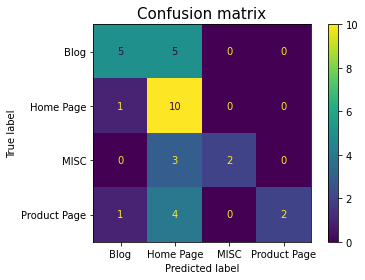

In [27]:
print_confusion_matrix(y_test, y_pred) # until row 262

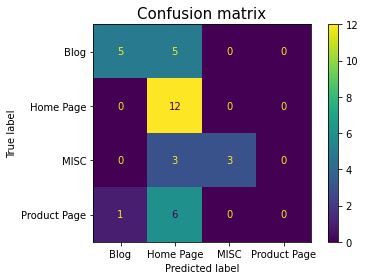

In [56]:
print_confusion_matrix(y_test, y_pred) # after (with more data) until row 281

#### Trying SVM (instead of Logistic Regression)

In [72]:
clf = fit_model(model=SVC(C=1.0,
                          class_weight='balanced', 
                          random_state=0), 
                X_train=X_train_transformed, 
                y_train=y_train)

In [73]:
y_pred = predict(clf, X_test=X_test_transformed)

In [75]:
get_accuracy(y_test, y_pred)

0.6571428571428571

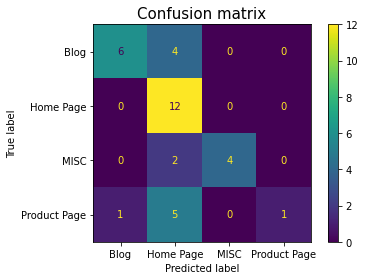

In [76]:
print_confusion_matrix(y_test, y_pred) # after (with more data) until row 281

In [84]:
clf = fit_model(model=SVC(C=1,
                          class_weight='balanced', 
                          random_state=0), 
                X_train=X_train_transformed, 
                y_train=y_train)

y_pred = predict(clf, X_test=X_test_transformed)

get_accuracy(y_test, y_pred)

0.6571428571428571

In [99]:
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=4000,
                                              random_state=0)), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1,
                   class_weight='balanced', 
                   random_state=0), )
]

# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_transformed, X_test_transformed, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.571429
RandomForest        0.542857
KNN 5               0.685714
SVM C1              0.657143
Best classifier: KNN 5, test accuracy: 0.686


In [107]:
def print_search_results(est, X_test, y_test):
    print('Best parameters set found on validation set:', est.best_params_)
    print(f'Best validation score: {est.best_score_:.3f}')

    means = est.cv_results_['mean_test_score']
    stds = est.cv_results_['std_test_score']
    params_all = est.cv_results_['params']
    print('\nScores on validation set:')
    for mean_score, std_score, params in zip(means, stds, params_all):
        print(f'{mean_score:.3f} (+/-{(std_score * 2):.3f}) for {params}')

    print("\nDetailed classification report:")
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    y_pred = est.predict(X_test)
    print(classification_report(y_test, y_pred))

In [123]:
# def grid_search_knn(X_train, y_train): # To use when I have more data for cross validation (cv)
#   metric = 'accuracy'

#   params_dict_knn = [{
#       'metric': ['minkowski', 'euclidean'], 
#       'n_neighbors': [4, 5, 6, 7], 
#       'weights': ['uniform', 'distance'],
#       'algorithm':['auto', 'ball_tree']}]

#   print(f'KNN Tuning hyper-parameters for {metric}')

#   clf_knn = GridSearchCV(KNeighborsClassifier(), 
#                         params_dict_knn, 
#                         scoring=metric, 
#                         cv=5, 
#                         verbose=10,
#                         n_jobs=-1)

#   return clf_knn.fit(X_train, y_train)

# clf_knn = grid_search_knn(X_train_transformed, y_train)
# print_search_results(clf_knn, X_test_transformed, y_test)